In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
from explore import xgb_rank
from model import get_scaled_df
import numpy as np
import pandas as pd

# Visualizing
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import sys # used in command to make entire array print by default


# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

# data manipulation 
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn import svm
from sklearn import metrics
import math
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def filter_columns(df,listofcolumns):
    #   ''' arguments - (dataframe), columns to include in returned dataframe
    #  ''' 
    newdf = df.copy()
    col_list = df.columns 
    for column in col_list:
        if column not in listofcolumns:
            newdf.drop([column], axis=1, inplace=True)
    return newdf

def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict




def linreg(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    r2_train = r2_score(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train.recovery, y = y_pred.ravel())
    reg_df = pd.DataFrame(lr.coef_, columns=X_vars)
    reg_df = reg_df.transpose().sort_values(by=0, ascending=False)
    reg_df.rename(index=str, columns={0: 'value'}, inplace=True)
    abs_df = reg_df.copy()
    abs_df['value'] = abs(abs_df['value'])
    abs_df.sort_values(by='value', ascending=False)
    return reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter

def ridge(X_train, y_train):
    rr = Ridge(alpha=.5)
    rr.fit(X_train, y_train)
    y_pred = rr.predict((X_train))
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train, y = y_pred.ravel())
    return rr, rr.coef_, rr.intercept_, MAE, MSE, y_pred, scatter

def svm(X_train, y_train):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
    y_rbf = svr_rbf.fit(X_train, y_train).predict(X_train)
    y_lin = svr_lin.fit(X_train, y_train).predict(X_train)
    y_poly = svr_poly.fit(X_train, y_train).predict(X_train)
    MSE_rbf = mean_squared_error(y_train, y_rbf)
    MSE_lin = mean_squared_error(y_train, y_lin)
    MSE_poly = mean_squared_error(y_train, y_poly)
    return svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly

In [3]:
df = acquire_oil()
df = prep_data(df)
df.reset_index(inplace=True)
df.shape

(7888, 61)

In [4]:
# df.isnull().sum()

In [5]:
df.drop(columns=['api14', 'sur_lat', 'sur_long', 'well_id']).describe()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,...,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,...,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,1129.177020,1142.213462,5732.858773,3.204488,1.862447,508.725133,120.070635,385.288562,3888.944514,349.246186,...,0.284274,0.380934,0.421953,0.045778,0.027389,0.194749,0.520577,0.393372,0.647040,0.895554
std,656.539972,714.303891,2945.296014,9.336062,9.188722,443.645469,95.660116,387.207769,3815.982884,315.135247,...,0.165447,0.238298,0.216933,0.133372,0.135128,0.191106,0.254807,0.145262,0.208235,0.136712
min,1.098097,0.354610,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,525.892109,499.423181,4056.250000,0.000000,0.000000,159.810463,46.481500,110.739000,1422.937793,94.906605,...,0.132247,0.166494,0.298464,0.000000,0.000000,0.071251,0.462055,0.280652,0.579955,0.900000
50%,1156.356260,1222.371400,6242.000000,0.000000,0.000000,429.084519,101.236000,284.305000,2491.502805,292.328796,...,0.291123,0.407675,0.459453,0.000000,0.000000,0.124765,0.589809,0.383685,0.696075,0.933333
75%,1594.793975,1653.074860,7723.250000,0.000000,0.000000,732.588900,172.310750,542.369000,4906.603828,508.700090,...,0.401608,0.551362,0.568553,0.000000,0.000000,0.245714,0.693837,0.478842,0.797456,0.950000
max,3969.384520,2997.879640,13581.000000,70.000000,68.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create Dataframe with Numeric Data

In [6]:
# df.info()

## Get scaled data into scaled_df

In [7]:
scaled_df = get_scaled_df(df)

In [8]:
scaled_df.columns

Index(['direction', 'frac_fluid_type', 'county', 'oper', 'formation',
       'lateral_class', 'proppant_ppf', 'frac_fluid_gpf', 'gross_perfs',
       'frac_stages', 'oil_gravity', 'gor_hist', 'tvd', 'mid_point_lat',
       'mid_point_long', 'vintage'],
      dtype='object')

In [9]:
scaled_df.head()

,direction,frac_fluid_type,county,oper,formation,lateral_class,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,gor_hist,tvd,mid_point_lat,mid_point_long,vintage
0,0.0,0.875,0.0,0.250000,0.763158,0.230769,0.330291,0.547863,0.292627,0.000000,0.0,0.087056,0.745943,0.614855,0.580622,0.966667
1,0.0,0.375,0.0,0.196970,0.763158,0.000000,0.274039,0.498082,0.536127,0.000000,0.0,0.069179,0.726813,0.517410,0.581774,0.916667
2,0.0,0.000,0.0,0.628788,0.763158,0.000000,0.239618,0.456706,0.543419,0.000000,0.0,0.098218,0.803781,0.587606,0.571086,0.916667
3,0.0,0.375,0.0,0.628788,0.763158,0.000000,0.290872,0.433468,0.543419,0.442857,0.0,0.066373,0.707608,0.592304,0.570250,0.916667
4,0.0,0.875,0.0,0.196970,0.763158,0.000000,0.323353,0.532564,0.518966,0.000000,0.0,0.141055,0.754652,0.576165,0.563362,0.933333


## Scale the gross_perfs limit:

In [10]:
df.gross_perfs.min()

4.0

In [11]:
df.gross_perfs.max()

13581.0

In [12]:
gross_perfs_scaled_limit = (6000 - df.gross_perfs.min()) / (df.gross_perfs.max() - df.gross_perfs.min())

In [13]:
gross_perfs_scaled_limit

0.44162922589673714

In [14]:
scaled_df.sample(3)

,direction,frac_fluid_type,county,oper,formation,lateral_class,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,gor_hist,tvd,mid_point_lat,mid_point_long,vintage
338,0.0,0.375,0.162162,0.314394,0.763158,0.000000,0.294294,0.383583,0.566031,0.428571,0.0,0.199822,0.490397,0.174956,0.848778,0.916667
1680,1.0,0.375,0.405405,0.071970,0.631579,1.000000,0.067648,0.162860,0.095161,0.000000,0.0,0.250635,0.000000,0.598260,0.735652,0.916667
1714,0.0,0.375,0.405405,0.852273,0.763158,0.692308,0.308582,0.484795,0.684540,0.542857,0.0,0.028927,0.588879,0.621041,0.760372,0.950000


## Visualize Data

### Attribute Histograms

In [15]:
scaled_df.columns

Index(['direction', 'frac_fluid_type', 'county', 'oper', 'formation',
       'lateral_class', 'proppant_ppf', 'frac_fluid_gpf', 'gross_perfs',
       'frac_stages', 'oil_gravity', 'gor_hist', 'tvd', 'mid_point_lat',
       'mid_point_long', 'vintage'],
      dtype='object')

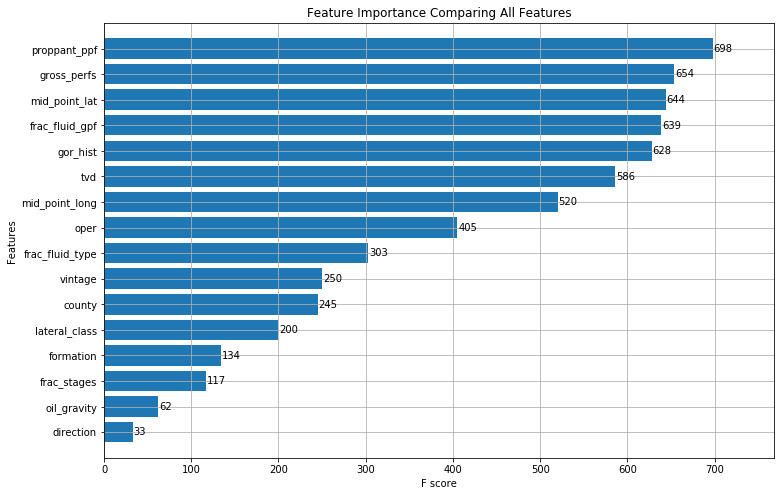

In [16]:
xgb_df = scaled_df.copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance Comparing All Features')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

### Create a viz of features ranked by gain

#### Get ranked features and that dataframe

In [17]:
ranked_features, best_df = xgb_rank(df, df.recovery)
ranked_features

['oil_gravity',
 'tvd',
 'vintage',
 'gross_perfs',
 'mid_point_lat',
 'mid_point_long',
 'formation']

['oil_gravity', 'tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'formation']

In [18]:
best_df

,rank,feature,gain,cum_sum,cum_perc
0,1.0,oil_gravity,223723.56,223723.56,27.75
1,2.0,tvd,114789.92,338513.48,41.99
2,3.0,vintage,88838.19,427351.67,53.01
3,4.0,gross_perfs,56380.65,483732.32,60.01
4,5.0,mid_point_lat,50247.11,533979.43,66.24
5,6.0,mid_point_long,46450.81,580430.24,72.01
6,7.0,formation,41038.99,621469.23,77.10
7,8.0,frac_stages,32487.35,653956.58,81.13
8,9.0,frac_fluid_gpf,29068.06,683024.64,84.73
9,10.0,direction,22169.15,705193.79,87.48


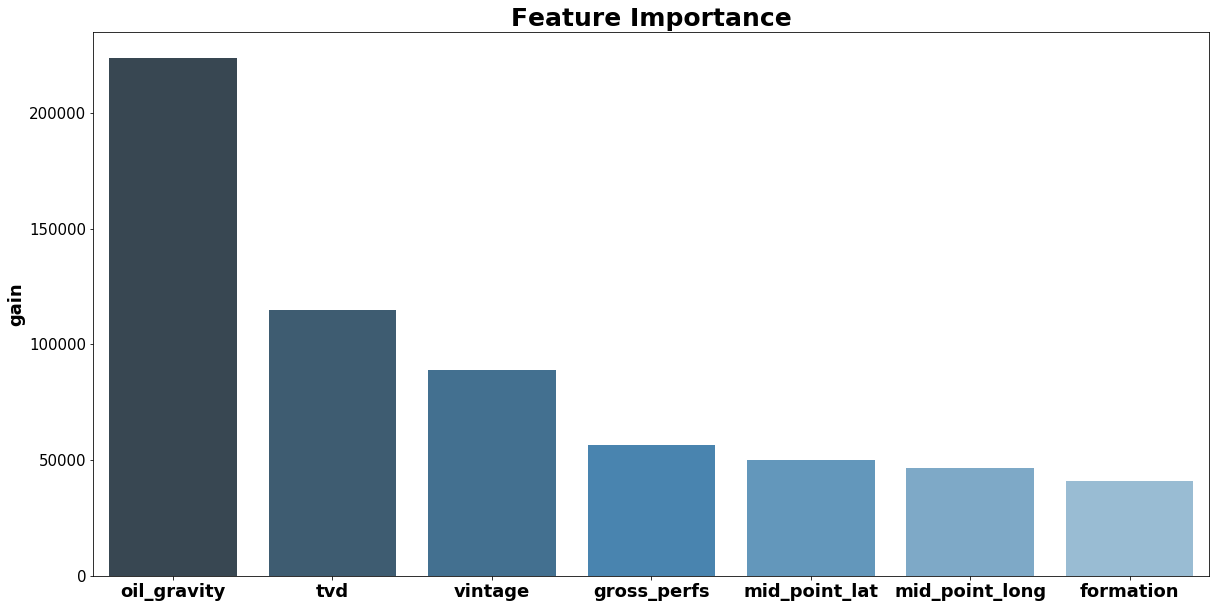

In [19]:
# Create a list of integers to use for xticks
c = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

plt.figure(figsize=(20,10))
sns.barplot(x='feature', y='gain', data=best_df[:len(ranked_features)], palette="Blues_d").tick_params(labelsize=15)

group_labels = ranked_features

# take the length of ranked_features and plot that many features
plt.xticks(c[0:len(ranked_features)] , group_labels, weight='bold', fontsize=18)
plt.yticks()

plt.title('Feature Importance', weight='bold').set_fontsize('25')
plt.xlabel('')
plt.ylabel('gain', weight='bold').set_fontsize('18')

plt.show()

#### Run the regression with all of the features:

In [20]:
X_vars = scaled_df.columns
X_vars

Index(['direction', 'frac_fluid_type', 'county', 'oper', 'formation',
       'lateral_class', 'proppant_ppf', 'frac_fluid_gpf', 'gross_perfs',
       'frac_stages', 'oil_gravity', 'gor_hist', 'tvd', 'mid_point_lat',
       'mid_point_long', 'vintage'],
      dtype='object')

In [21]:
df.recovery.max()

999.3054703333332

lr.intercept: 64.58888477333744
MAE: 47.684237501361864
MSE: 13555.379524016389
r2_train: 0.30209541667035156


,value
gross_perfs,262.670397
oil_gravity,183.189069
tvd,152.990516
mid_point_lat,79.837743
gor_hist,60.964669
direction,58.734352
formation,54.345330
proppant_ppf,24.039695
frac_fluid_gpf,16.504191
county,2.490560


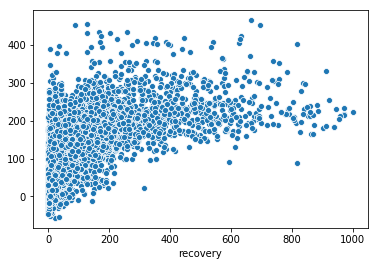

In [22]:
# Independent variables:
X_vars = scaled_df.columns

# ['direction', 'frac_fluid_type', 'county', 'oper', 'formation',
#  'lateral_class', 'proppant_ppf', 'frac_fluid_gpf', 'gross_perfs',
#  'frac_stages', 'oil_gravity', 'gor_hist', 'tvd', 'mid_point_lat',
#  'mid_point_long', 'vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [23]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
gross_perfs,262.670397
oil_gravity,183.189069
tvd,152.990516
vintage,152.551599
mid_point_long,100.090774
mid_point_lat,79.837743
gor_hist,60.964669
direction,58.734352
formation,54.345330
proppant_ppf,24.039695


#### Filter all features for only vertical wells:

In [26]:
df.columns

Index(['index', 'api14', 'lease_name', 'well_number', 'county', 'direction',
       'status', 'oper', 'multi_well_lease', 'major_phase', 'formation',
       'proppant_ppf', 'prod_method', 'frac_fluid_gpf', 'gross_perfs',
       'frac_stages', 'frac_fluid_type', 'first_prod', 'last_prod',
       'oil_gravity', 'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist',
       'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat',
       'mid_point_long', 'sub_basin', 'recovery', 'recovery_per_foot',
       'months_active', 'recovery_per_month', 'lateral_class', 'vintage',
       'vintage_bin', 'encoded_direction', 'encoded_frac_fluid_type',
       'encoded_county', 'encoded_oper', 'encoded_formation',
       'encoded_lateral_class', 'scaled_direction', 'scaled_frac_fluid_type',
       'scaled_county', 'scaled_oper', 'scaled_formation',
       'scaled_lateral_class', 'scaled_proppant_ppf', 'scaled_frac_fluid_gpf',
       'scaled_gross_perfs', 'scaled_frac_stages', 'scaled_oil_gra

In [25]:
df_vert = prep_data(df,basin='all',direc='vertical',tvdmin=0,tvdmax=0,gperfmin=0,gperfmax=0,multiwell='all',clusterid=99)
# df_vert_scaled = get_scaled_df(df)
# df_vert_scaled.head(2)

AttributeError: 'DataFrame' object has no attribute 'oil_eur'

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

# These lines are to filter for only vertical wells:
df_vert = scaled_df[scaled_df.scaled_direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

#### Test only top features suggested by XGBoost, without filtering for vertical wells.

In [ ]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd', 
          'scaled_frac_fluid_gpf', 'scaled_oper']
# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

#### Test only top features suggested by XGBoost (exclude peak_boepd), WITH filtering for vertical wells.

In [ ]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_gor_hist', 'scaled_tvd', 
          'scaled_frac_fluid_gpf', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.scaled_direction == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

# Run XGBoost for each sub-basin:

#### CP, Central Platform, including all features:

In [ ]:
CP_df = scaled_df[(scaled_df['scaled_sub_basin'] == 0)]
CP_df.sample(5)

In [ ]:
xgb_df = CP_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, CP_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Central Platform Sub-basin')
plt.show()

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = CP_df[X_vars].copy()                                                    
y = CP_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

#### Delaware:

In [ ]:
Del_df = scaled_df[(scaled_df['scaled_sub_basin'] == 0.5)]
Del_df.sample(5)

In [ ]:
xgb_df = Del_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Del_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Delaware Sub-basin')
plt.show()

# I think we can return xgb and model to then plot xgb.plot_importance(model,...)
# Or maybe can save that line into a variable to return.

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Del_df[X_vars].copy()                                                    
y = Del_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

#### Midland:

In [ ]:
Mid_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1)]
Mid_df.sample(5)

In [ ]:
xgb_df = Mid_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Feature Importance of Midland Sub-basin')
plt.show()

Recommended features for XGB:

X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf',
              'scaled_tvd', 'scaled_oper']

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']


# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_df[X_vars].copy()                                                    
y = Mid_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

Recommended features:

XGB X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf',
              'scaled_tvd', 'scaled_oper']


LM X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 'scaled_vintage', 
             'scaled_direction', 'scaled_formation']

#### Midland, horizontal wells only:

In [ ]:
scaled_df.scaled_direction.value_counts()

In [ ]:
Mid_Hor_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]
Mid_Hor_df.sample(5)

In [ ]:
xgb_df = Mid_Hor_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells Only')
plt.show()

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars].copy()                                                    
y = Mid_Hor_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

#### Midland, vertical wells only:

In [ ]:
Mid_Ver_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 1.0)]
Mid_Ver_df.sample(5)

In [ ]:
xgb_df = Mid_Ver_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Ver_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Vertical Wells Only')
plt.show()

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Ver_df[X_vars].copy()                                                    
y = Mid_Ver_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

#### Midland, Horizontal Wells, Gross Perforations < 6000:

In [ ]:
Mid_Hor_Low_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] < gross_perfs_scaled_limit)]
Mid_Hor_Low_df.sample(5)

In [ ]:
xgb_df = Mid_Hor_Low_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_Low_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations < 6000')
plt.show()

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_Low_df[X_vars].copy()                                                    
y = Mid_Hor_Low_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

#### Midland, Horizontal Wells, Gross Perforations > 6000:

In [ ]:
((scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] < gross_perfs_scaled_limit)).sum()

In [ ]:
((scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] > gross_perfs_scaled_limit)).sum()

In [ ]:
Mid_Hor_High_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0) & (scaled_df['scaled_gross_perfs'] > gross_perfs_scaled_limit)]
Mid_Hor_High_df.sample(5)

In [ ]:
xgb_df = Mid_Hor_High_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, Mid_Hor_High_df.recovery, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.title('Midland, Horizontal Wells, Gross Perforations > 6000')
plt.show()

In [ ]:
# Independent variables:
X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
          'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
          'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
          'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
          'scaled_tvd', 'scaled_vintage']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_High_df[X_vars].copy()                                                    
y = Mid_Hor_High_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, r2_train, y_pred, scatter = linreg(X_train, y_train)
print('lr.intercept:', lr.intercept_[0])
print('MAE:', MAE)
print('MSE:', MSE)
print('r2_train:', r2_train)
reg_df

In [ ]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

## Test Harness and Options

### SVR

#### First try on Midland sub-basin, horizontal wells.

In [ ]:
Mid_Hor_df = scaled_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]
Mid_Hor_df.sample(5)

Recommended features:

XGB X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf',
              'scaled_tvd', 'scaled_oper']


LM X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 'scaled_vintage', 
             'scaled_direction', 'scaled_formation']

In [ ]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

# R² is a statistical measure of how close the data are to the fitted 
# regression line. 
# R² is the percentage of the response variable variation that is 
# explained by a linear model. Or:
# R² = Explained variation / Total variation
# R² is always between 0 and 100%:
# 0% indicates that the model explains none of the variability of the response data around its mean.
# 100% indicates that the model explains all the variability of the response data around its mean.
# In general, the higher the R-squared, the better the model fits your data. 

# Root Mean Square Error (RMSE) is the standard deviation of the 
# residuals (prediction errors), a measure of how spread out these 
# residuals are. In other words, it tells you how concentrated the data 
# is around the line of best fit.

# The mean squared error (MSE) of an estimator measures the average of 
# the squares of the errors—that is, the average squared difference 
# between the estimated values and what is estimated. 

In [ ]:
X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 
          'scaled_vintage', 'scaled_direction', 'scaled_formation']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

In [ ]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

In [ ]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='linear', gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

#### poly kernel is best, but r2 is only .055.

In [ ]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2, degree=25)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

#### using features from linear regression model is even better, but still only r2 = .057.

In [ ]:
X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 
          'scaled_vintage', 'scaled_direction', 'scaled_formation']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2, verbose=True)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

#### Tried "cheating" by adding mid_point_long and mid_point_lat, but still r2 = .06.

In [ ]:
numerics = ['int64', 'float64', 'float']

temp_df = df.select_dtypes(include=numerics)
temp_df = temp_df.drop(columns=['api14', 'proppant_ppf', 'frac_fluid_gpf', 
        'gross_perfs', 'frac_stages', 'oil_gravity', 'peak_boepd', 'oil_hist', 
        'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long', 
        'well_id', 'mid_point_lat', 'mid_point_long', 'recovery_per_foot', 
        'months_active', 'recovery_per_month', 'vintage', 'vintage_bin', 
        'encoded_direction', 'encoded_frac_fluid_type', 'encoded_county', 
        'encoded_oper', 'encoded_formation', 'encoded_sub_basin', 'encoded_lateral_class', 
        'scaled_county'])
temp_Mid_Hor_df = temp_df[(scaled_df['scaled_sub_basin'] == 1) & (scaled_df['scaled_direction'] == 0.0)]

In [ ]:
# X_vars = ['scaled_direction', 'scaled_frac_fluid_type', 'scaled_oper', 
#           'scaled_formation', 'scaled_sub_basin', 'scaled_lateral_class', 
#           'scaled_proppant_ppf', 'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 
#           'scaled_frac_stages', 'scaled_oil_gravity', 'scaled_gor_hist', 
#           'scaled_tvd', 'scaled_vintage']

X_vars = ['scaled_gross_perfs', 'scaled_oil_gravity', 'scaled_tvd', 
          'scaled_vintage', 'scaled_direction', 'scaled_formation',
          'scaled_mid_point_lat', 'scaled_mid_point_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = temp_Mid_Hor_df[X_vars]
y = temp_Mid_Hor_df[target]

m = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

In [ ]:
print(__doc__)

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [ ]:
print(__doc__)

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
#           'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']
X_vars = ['scaled_proppant_ppf']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=.2)
svr_lin = SVR(kernel='linear', C=1.0, gamma='scale')
svr_poly = SVR(kernel='poly', C=1.0, gamma='scale', degree=3, epsilon=.2,
               coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    print(ix)
    print(svr)
    print()
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
#     axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
#                      edgecolor=model_color[ix], s=50,
#                      label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      y[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      facecolor="none", edgecolor="k", s=50,
#                      label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

# This is the code that worked above, but only on one at a time.
# m = SVR(gamma='scale', C=1.0, epsilon=0.2)
# m_fit = m.fit(X, y) 
# y_pred = m_fit.predict(X)
# plt.plot(y_pred, 'r-', y, 'b-')

# plt.figure(figsize=(8,8))
# ax = plt.subplot(1, 1, 1)
# ax.plot(y_pred, y, '.')
# plt.show()

### From curriculum:

In [ ]:
SVR_XGB_df = Mid_Hor_df[['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']]
SVR_XGB_df.sample(5)

In [ ]:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]

m = SVR(gamma='scale', C=1.0, epsilon=0.2)
m_fit = m.fit(X, y) 
y_pred = m_fit.predict(X)
# mean squared error
mse = metrics.mean_squared_error(y_pred, y)
# root mean squared error
rmse = math.sqrt(mse)
# r^2
r2 = r2_score(y, y_pred)
print('r2: ', r2, '   rmse:', rmse, '   mse:', mse)
plt.plot(y_pred, 'r-', y, 'b-')

plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y, '.')
plt.show()

In [ ]:
# Independent variables:
X_vars = ['scaled_proppant_ppf', 'scaled_gor_hist', 'scaled_gross_perfs', 
          'scaled_frac_fluid_gpf', 'scaled_tvd', 'scaled_oper']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = Mid_Hor_df[X_vars]
y = Mid_Hor_df[target]


# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = np.array(pd.concat([X_train, y_train], axis=1))
test = np.array(pd.concat([X_test, y_test], axis=1))

#### Create the Support Vector Regressor Object

In [ ]:
m = SVR(kernel='rbf', C=1, gamma=0.1)
# C is our regularization constant
m_fit = m.fit(X_train, y_train)

#### Predict in-sample/training dataset

In [ ]:
y_pred = m_fit.predict(X_train)

#### Evaluate

In [ ]:
# mean squared error
mse = metrics.mean_squared_error(y_pred, y_train)
print(mse)

In [ ]:
# root mean squared error
import math
rmse = math.sqrt(mse)
print(rmse)

#### Plot the predicted data

In [ ]:
plt.plot(y_pred, 'b-', y_train, 'r-')

#### Plot the predicted values with the actual values

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(y_pred, y_train, '.')
plt.show()

#### Predict on out-of-sample/test dataset

In [ ]:
y_pred = m_fit.predict(X_test)

#### Evaluate

In [ ]:
# mean squared error
mse = metrics.mean_squared_error(y_pred, y_test)
print(mse)

In [ ]:
# root mean squared error
import math
rmse = math.sqrt(mse)
print(rmse)

#### Plot Predictions

In [ ]:
plt.plot(y_pred, 'b-', y_test, 'r-')

# Need to add filter_columns for the following to work.

## Explore and select algorithms

In [ ]:
def filter_columns(df,listofcolumns):
    #   ''' arguments - (dataframe), columns to include in returned dataframe
    #  ''' 
    newdf = df.copy()
    col_list = df.columns 
    for column in col_list:
        if column not in listofcolumns:
            newdf.drop([column], axis=1, inplace=True)
    return newdf

In [ ]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict


In [ ]:
X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
          'months_active', 'lateral_len', 'ip90_boeqpd', 'county']

lregressiontest(scaled_df, X_vars, 'recovery', .8)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering